# **Super Mario Bros. with Stable-Baseline3 PPO**





>Super Mario Bros is a well-known video game title developed and published by Nintendo in the 1980s. It is one of the classical game titles that lived through the years and need no explanations. It is a 2D side-scrolling game, allowing the player to control the main character — Mario.

>The gameplay involves moving Mario from left to right, surviving the villains, getting coins, and reaching the flag to clear stages. Mario would ultimately need to save the princess toadstool. These come with different reward systems, coins, villains, holes, and completion time.

>The game environment was taken from the OpenAI Gym using the Nintendo Entertainment System (NES) python emulator. In this article, I will show how to implement the Reinforcement Learning algorithm using stable-baseline3 PPO algorithm using PyTorch library in an easy and simple way.

>This project is broken into 3 parts:
1.   Installation of all necessary
2.   Pre-processing
3.   Training of the model
4.   Results and conclusions




>**So, Lets-a Go!**

## Installation of all necessary

>Before starting any kind of installation it is important to know the version of Python we are working with.  This project has been developed mainly in Google Colab, but due to the limitations when rendering the game, the Visual Studio development environment has also been used.  

>It is convenient that both environments share the same version of Python. In my case, I had different problems when loading the models due to the dissimilarity of the versions.

In [2]:
!python --version

/bin/bash: line 1: python: command not found


>As mentioned above, the OpenAI Gym environment has been used. In the case of the project, version 0.21.0 has been used. Be careful with the version of the enviroments, since some later versions are not stable with Stable-Baseline3.

In [3]:
pip install gym==0.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.8 MB/s eta 0:00:00a 0:00:010m
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 18.3 MB/s eta 0:00:0000:0100:01
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616826 sha256=bf5b25fe73d39334aa05c5e00acaaed54ef2984b6a9ba1cd56fb13c09bab42ea
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
Note: you may need to restart the kernel to use updated packages.


>The next step is to install the Super Mario Bros. game. [Super Mario Bros](https://pypi.org/project/gym-super-mario-bros/)

>In case you are **not using Google Colab**, you will need your computer to have the C++ compiler. From my point of view, the easiest way is, to download Visual Studio Code and in the installation download its C++ compiler.

In [4]:
!pip install -qq gym-super-mario-bros

>In order to train the artificial intelligence, the PPO algorithm of stable-baseline3 will be used.

In [5]:
!pip -qq install stable-baselines3==1.6.0

In [6]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 27.8 MB/s eta 0:00:0000:0100:01


## First steps

>Before starting the enviroment pre-processing, it is necessary to understand how the game enviroment works.

>On the one hand, gym-super-mario-bros offers different types of enviroment. In this project two models will be trained, each with one type of enviroment version.  By this, we want to analyze the differences between training a model with the standard version and a model with the rectangle version.

>Enviroment with standart version : 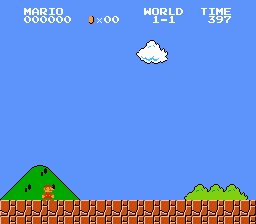        
                                                                                >Enviroment with rectangle version : 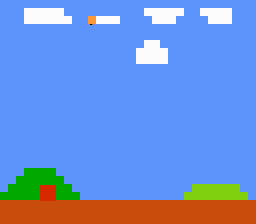



In [1]:
import gym_super_mario_bros
#The 1-1 specifies the map to be loaded
STAGE_NAME = 'SuperMarioBros-1-1-v0' # Standar versión
#STAGE_NAME = 'SuperMarioBros-1-1-v3' # Rectangle versión
env = gym_super_mario_bros.make(STAGE_NAME) #Create the enviroment

>The next step would be to specify the moves that our Mario could make. The enviroment brings us by default certain predefined movements, although we can create our own as we will see in the section of pre processing.

In [2]:
from nes_py.wrappers import JoypadSpace

from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from gym_super_mario_bros.actions import RIGHT_ONLY
print("Simple Movements : ", SIMPLE_MOVEMENT)
print("Complex Movements : ", COMPLEX_MOVEMENT)
print("Right Only Movements : ", RIGHT_ONLY)
env = JoypadSpace(env, SIMPLE_MOVEMENT) #specify the movements

Simple Movements :  [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]
Complex Movements :  [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left'], ['left', 'A'], ['left', 'B'], ['left', 'A', 'B'], ['down'], ['up']]
Right Only Movements :  [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B']]


>With these steps we can start playing with mario bros. 

In [3]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

done = True
for step in range(5000):
    if done: # Done will be true if Mario dies in the game
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    #env.render() # If we are running the program in Colab we will need to comment the rendering of the environment. 
env.close()

## Pre-procesing

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv


>This section analyzes the pre-processing that has been done to the environment. On the one hand, we have the SkipFrame function. By default, in each frame the game performs an action (a movement) and returns the reward for that action. What happens, is that to train the AI it is not necessary to make a move in each frame. That is why, the function executes the movement every X frames giving less work to do the training.

In [5]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

>The second step is the re-scaling of our environment. By default the enviroment is given by 240*256 pixels. In order to optimize our model it is not necessary to have so many pixels and that is why we can rescale our enviroment to a smaller scale.

In [6]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
state = env.reset()
print(state.shape)

(240, 256, 3)


In [7]:
class ResizeEnv(gym.ObservationWrapper):
    def __init__(self, env, size):
        gym.ObservationWrapper.__init__(self, env)
        (oldh, oldw, oldc) = env.observation_space.shape
        newshape = (size, size, oldc)
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=newshape, dtype=np.uint8)

    def observation(self, frame):
        height, width, _ = self.observation_space.shape
        frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        if frame.ndim == 2:
            frame = frame[:,:,None]
        return frame

>On the other hand, there is the environment reward function. By default,the reward function assumes the objective of the game is to move as far right as possible (increase the agent's x value), as fast as possible, without dying. To model this game, three separate variables compose the reward:



1.   v: the difference in agent x values between states
* in this case this is instantaneous velocity for the given step
* v = x1 - x0
* x0 is the x position before the step
* x1 is the x position after the step
* moving right ⇔ v > 0
* moving left ⇔ v < 0
* not moving ⇔ v = 0
2. c: the difference in the game clock between frames
* the penalty prevents the agent from standing still
* c = c0 - c1
* c0 is the clock reading before the step
* c1 is the clock reading after the step
* no clock tick ⇔ c = 0
* clock tick ⇔ c < 0
3. d: death penalty that penalizes the agent for dying in a state
* this penalty encourages the agent to avoid death
* alive ⇔ d = 0
* dead ⇔ d = -15

>r = v + c + d

>The reward is clipped into the range (-15, 15).
It is in this function that we can start to try new things, such as creating an AI that prioritizes obtaining coins.

In [8]:
class CustomRewardAndDoneEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(CustomRewardAndDoneEnv, self).__init__(env)
        self.current_score = 0
        self.current_x = 0
        self.current_x_count = 0
        self.max_x = 0
    def reset(self, **kwargs):
        self.current_score = 0
        self.current_x = 0
        self.current_x_count = 0
        self.max_x = 0
        return self.env.reset(**kwargs)
    def step(self, action):
        state, reward, done, info = self.env.step(action)
        reward += max(0, info['x_pos'] - self.max_x)
        if (info['x_pos'] - self.current_x) == 0:
            self.current_x_count += 1
        else:
            self.current_x_count = 0
        if info["flag_get"]:
            reward += 500
            done = True
            print("GOAL")
        if info["life"] < 2:
            reward -= 500
            done = True
        self.current_score = info["score"]
        self.max_x = max(self.max_x, self.current_x)
        self.current_x = info["x_pos"]
        return state, reward / 10., done, info

>By default the environment is composed of the RGB room. This data is unnecessary when training our model and we will get better results if we convert our game to a grayscale.

In [9]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
state = env.reset()
print("RGB scale : ",state.shape)
env = GrayScaleObservation(env, keep_dim=True)
state = env.reset()
print("Gray scale:",state.shape)

RGB scale :  (240, 256, 3)
Gray scale: (240, 256, 1)


>Finally, it is important to group the frames when training. If you only train with one frame the AI will not be able to know where Mario or the enemies are moviing. This is why a FrameStack of 4 frames is created for training.

In [10]:
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

>This is the final pre-processing

In [11]:
MOVEMENT = [['left', 'A'], ['right', 'B'], ['right', 'A', 'B']]
env = gym_super_mario_bros.make(STAGE_NAME)
env = JoypadSpace(env, MOVEMENT)
env = CustomRewardAndDoneEnv(env)
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env, keep_dim=True)
env = ResizeEnv(env, size=84)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [12]:
env.reset()
state, reward, done, info = env.step([0])
print('state:', state.shape) #Color scale, height, width, num of stacks

state: (1, 84, 84, 4)


In [13]:
def display_all_frame():
    plt.figure(figsize=(16,16))
    for idx in range(state.shape[3]):
        plt.subplot(1,4,idx+1)
        plt.imshow(state[0][:,:,idx])
    plt.show()

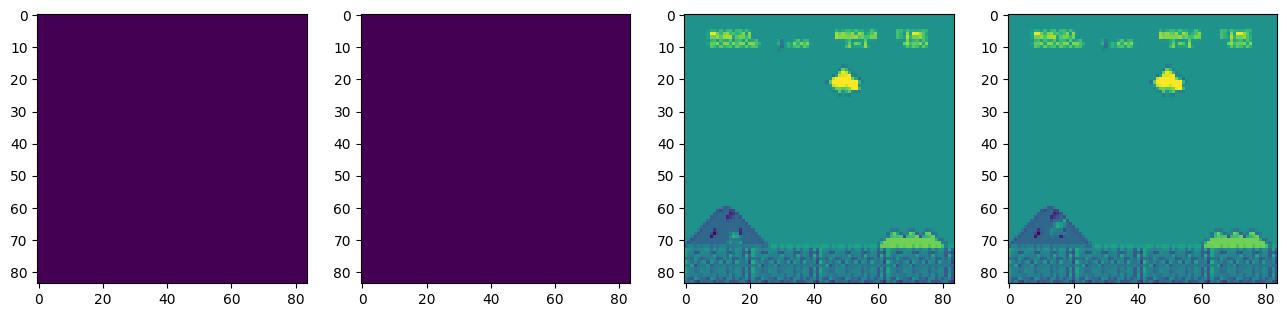

In [14]:
display_all_frame()

## Training of the model

In [15]:
# Import PPO for algos
from stable_baselines3 import PPO
import torch as th
from torch import nn

# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

In [16]:
# Model Param
CHECK_FREQ_NUMB = 10000
TOTAL_TIMESTEP_NUMB = 5000000
LEARNING_RATE = 0.0001
GAE = 1.0
ENT_COEF = 0.01
N_STEPS = 512
GAMMA = 0.9
BATCH_SIZE = 64
N_EPOCHS = 10

# Test Param
EPISODE_NUMBERS = 20
MAX_TIMESTEP_TEST = 1000

>Once the environment has been preprocessed, it is time to start training our AI model. In this case the stable-baseline3 PPO algorithm will be used due to its simplicity, but other alternatives such as DQN or DDQN can be explored. Before starting with the training, a convolutional neural network (CNN) has been created.

>

In [17]:
class MarioNet(BaseFeaturesExtractor):

    def __init__(self, observation_space: gym.spaces.Box, features_dim):
        super(MarioNet, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(th.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=MarioNet,
    features_extractor_kwargs=dict(features_dim=512),
)

>The next step consists of the creation of a file where the AI will save the results obtained in each iteration. In this way, later we will be able to visualize graphically the learning of our model.

>In this case, the average score, the average starting time and the best score obtained will be saved for each iteration.

In [18]:
from pathlib import Path
import datetime
from pytz import timezone
save_dir = Path('./model')
save_dir.mkdir(parents=True, exist_ok = True)
reward_log_path = (save_dir / 'reward_log.csv')

In [19]:
with open(reward_log_path, 'a') as f:
    print('timesteps,reward,best_reward', file=f)

>This callback function will be in charge of writing the aforementioned data to the file. This function will be executed automatically each time an iteration has been completed.

In [20]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = (save_dir / 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

            total_reward = [0] * EPISODE_NUMBERS
            total_time = [0] * EPISODE_NUMBERS
            best_reward = 0

            for i in range(EPISODE_NUMBERS):
                state = env.reset()  # reset for each new trial
                done = False
                total_reward[i] = 0
                total_time[i] = 0
                while not done and total_time[i] < MAX_TIMESTEP_TEST:
                    action, _ = model.predict(state)
                    state, reward, done, info = env.step(action)
                    total_reward[i] += reward[0]
                    total_time[i] += 1

                if total_reward[i] > best_reward:
                    best_reward = total_reward[i]
                    best_epoch = self.n_calls

                state = env.reset()  # reset for each new trial

            print('time steps:', self.n_calls, '/', TOTAL_TIMESTEP_NUMB)
            print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
                  'average time:', (sum(total_time) / EPISODE_NUMBERS),
                  'best_reward:', best_reward)

            with open(reward_log_path, 'a') as f:
                print(self.n_calls, ',', sum(total_reward) / EPISODE_NUMBERS, ',', best_reward, file=f)

        return True

>Finally, all that remains is for our AI to start learning. 

In [21]:
callback = TrainAndLoggingCallback(check_freq=CHECK_FREQ_NUMB, save_path=save_dir)

In [22]:
model = PPO('CnnPolicy', env, verbose=0, policy_kwargs=policy_kwargs, tensorboard_log=save_dir, learning_rate=LEARNING_RATE, n_steps=N_STEPS,
              batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, gamma=GAMMA, gae_lambda=GAE, ent_coef=ENT_COEF)

In [23]:
model.learn(total_timesteps=TOTAL_TIMESTEP_NUMB, callback=callback)

time steps: 10000 / 5000000
average reward: 249.2249962452799 average time: 136.1 best_reward: 420.09999468177557
GOAL
time steps: 20000 / 5000000
average reward: 262.0249958205968 average time: 121.05 best_reward: 726.6999883502722
time steps: 30000 / 5000000
average reward: 209.60999659374357 average time: 88.35 best_reward: 491.6999917551875
GOAL
time steps: 40000 / 5000000
average reward: 193.02499695941805 average time: 91.75 best_reward: 529.3999909907579
GOAL
time steps: 50000 / 5000000
average reward: 212.0449962966144 average time: 91.3 best_reward: 448.49999161064625
time steps: 60000 / 5000000
average reward: 250.54999570287765 average time: 101.45 best_reward: 525.2999902442098
time steps: 70000 / 5000000
average reward: 216.77999641261994 average time: 102.0 best_reward: 529.4999894499779
time steps: 80000 / 5000000
average reward: 193.1899966966361 average time: 83.2 best_reward: 531.4999916180968
time steps: 90000 / 5000000
average reward: 286.48999476097526 average time

KeyboardInterrupt: 

## Results and Conclusion

>This last section analyzes the results and conclusions of this project. As can be seen in the graphs, two different models have been trained, one using the standard set and the other using the rectangle set.

>In the standard game, 1050000 iteractions have been executed, while in the rectangular game there have been 640000.  Although the rectangular model has been trained with much fewer iterations, the best model has similar results to the best standard model. 

>If we run the function that calculates the win rate we can see that both models have a 20% win rate.

In [24]:
import pandas as pd
reward_log = pd.read_csv("reward_log_Standar.csv", index_col='timesteps')
reward_log.plot()

FileNotFoundError: [Errno 2] No such file or directory: 'reward_log_Standar.csv'

In [ ]:
import pandas as pd
reward_log = pd.read_csv("reward_log_Rectangle.csv", index_col='timesteps')
reward_log.plot()

In [ ]:
reward_log = pd.read_csv("reward_log_Standar.csv", index_col='timesteps')
best_epoch = reward_log['reward'].idxmax()
print('best epoch:', best_epoch)

In [ ]:
best_model_path = os.path.join(save_dir, 'best_model_{}'.format(best_epoch))
model = PPO.load(best_model_path)

In [ ]:
state = env.reset()
done = True
plays = 0;
wins = 0;
while plays < 100:
    if done:
        state = env.reset() 
        if info[0]["flag_get"]:
          wins += 1
        plays += 1
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
print("Model win rate: " + str(wins) + "%")

In [ ]:
state = env.reset()

while plays < 100:
    if done:
        state = env.reset() 
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    #env.render() #Only in local, not in Colab 

>[Demo](https://youtube.com/shorts/jta7SegNNwM)
<iframe width='560' height='315' src="https://youtube.com/shorts/jta7SegNNwM"/>